<a href="https://colab.research.google.com/github/SERVIR/RX_fires/blob/main/AGB_Stand_Age_Corretion_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Authenticate and initialize Earth Engine
import ee
import geemap
import geemap.chart as chart
ee.Authenticate()
ee.Initialize(project='servir-sco-assets')
Map = geemap.Map()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [3]:
# -------------------------------
# Setup
# -------------------------------
!pip install pandas matplotlib numpy


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
# -------------------------------
# Inputs
# -------------------------------
LLP = ee.Image("projects/servir-sco-assets/assets/Rx_Fire/EO_Inputs/LEO_extantLLP_significance")
LLP_binary = LLP.gt(0).selfMask()

# AOIs
EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')

# AGB 2019
agb = ee.ImageCollection('projects/sat-io/open-datasets/ESA/ESA_CCI_AGB')
agb_2019 = agb.filterDate('2019-01-01','2019-12-31').first().select(['AGB'])
pixelAreaHa = ee.Image.pixelArea().divide(10000)
agb_tons_per_pixel = agb_2019.multiply(pixelAreaHa).multiply(1.10231)

# Stand age rasters
stand_age_EIA_CS1 = ee.Image("projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/Conus_Stocking_Aga_Loreys_Height_2018_EIA_1")
stand_age_EIA_CS2 = ee.Image("projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/Conus_Stocking_Aga_Loreys_Height_2018_EIA_2")
stand_age_EIA_CS3 = ee.Image("projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/Conus_Stocking_Aga_Loreys_Height_2018_EIA_3")


['EIA_CS1_LLP' 'EIA_CS1_NonLLP' 'EIA_CS2_LLP' 'EIA_CS2_NonLLP'
 'EIA_CS3_LLP' 'EIA_CS3_NonLLP']


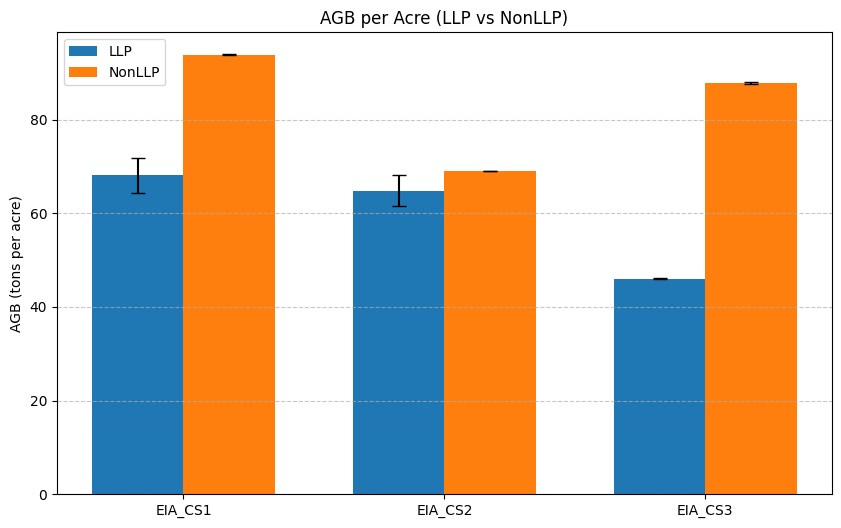


AGB and Stand Metrics per AOI (mean values):
    AOI   Type  AGB_per_acre_tons  AGB_StdDev_per_acre_tons  Stand_Age  Tree_stock_percent  Loreys_Height
EIA_CS1    LLP          68.108174                  3.700580  30.333296           55.036113      48.268221
EIA_CS1 NonLLP          93.837343                  0.101738  40.011936           53.278451      55.900457
EIA_CS2    LLP          64.821768                  3.299238  33.102288           59.935198      53.519144
EIA_CS2 NonLLP          68.949701                  0.033779  34.989240           54.602014      51.434014
EIA_CS3    LLP          46.050363                  0.138895  33.216996           54.698790      52.879525
EIA_CS3 NonLLP          87.768433                  0.164658  40.240248           53.101987      56.433242

+---------+--------+-------------------+--------------------------+--------------------+--------------------+--------------------+
|   AOI   |  Type  | AGB_per_acre_tons | AGB_StdDev_per_acre_tons |     Stand_Ag

In [16]:
# -------------------------------
# Biomass per polygon
# -------------------------------
def addTotalBiomass(fc, name):
    reduced = agb_tons_per_pixel.reduceRegions(
        collection=fc,
        reducer=(ee.Reducer.sum()
                 .combine(ee.Reducer.mean(), sharedInputs=True)
                 .combine(ee.Reducer.stdDev(), sharedInputs=True)),
        scale=100,
    )

    reduced = reduced.filter(ee.Filter.notNull(['sum']))

    def process(f):
        geom = f.geometry()
        area_m2 = ee.Number(geom.area(1))
        area_acres = area_m2.divide(4046.86)

        agb_sum = ee.Number(f.get('sum'))
        agb_mean = ee.Number(f.get('mean'))
        agb_std = ee.Number(f.get('stdDev'))

        agb_per_acre = ee.Algorithms.If(area_acres.neq(0), agb_sum.divide(area_acres), None)
        agb_std_per_acre = ee.Algorithms.If(area_acres.neq(0), agb_std.divide(area_acres), None)

        return f.set({
            'AOI_Zone': name,
            'AGB_Total_tons': agb_sum,
            'AGB_per_acre_tons': agb_per_acre,
            'AGB_Mean_tons_per_pixel': agb_mean,
            'AGB_StdDev_tons_per_pixel': agb_std,
            'AGB_StdDev_per_acre_tons': agb_std_per_acre
        })

    return reduced.map(process)

# -------------------------------
# LLP vs Non-LLP
# -------------------------------
def processAOI(aoi, name):
    llp_clip = LLP_binary.clip(aoi)

    llp_vec = llp_clip.reduceToVectors(
        geometry=aoi,
        scale=30,
        eightConnected=True,
        geometryType='polygon',
        bestEffort=True,
        maxPixels=1e13
    )

    llp_dissolved = llp_vec.union(1)
    non_llp = aoi.map(lambda f: f.difference(right=llp_dissolved.geometry(), maxError=1))

    stats_llp = addTotalBiomass(llp_vec, f"{name}_LLP")
    stats_non = addTotalBiomass(non_llp, f"{name}_NonLLP")

    return stats_llp.merge(stats_non)

# -------------------------------
# Stand/Stocking metrics
# -------------------------------
def addStandMetrics(fc, standImg):
    clippedImg = standImg.clipToCollection(fc)

    reduced = clippedImg.reduceRegions(
        collection=fc,
        reducer=ee.Reducer.mean(),
        scale=30,
    )

    def rename(f):
        return f.set({
            'Tree_stock_percent': f.get('b1'),
            'Stand_Age': f.get('b2'),
            'Loreys_Height': f.get('b3'),
            # keep AOI_Zone from input, don't overwrite
            'AOI_Zone': f.get('AOI_Zone'),

            # re-attach AGB values
            'AGB_Total_tons': f.get('AGB_Total_tons'),
            'AGB_per_acre_tons': f.get('AGB_per_acre_tons'),
            'AGB_Mean_tons_per_pixel': f.get('AGB_Mean_tons_per_pixel'),
            'AGB_StdDev_tons_per_pixel': f.get('AGB_StdDev_tons_per_pixel'),
            'AGB_StdDev_per_acre_tons': f.get('AGB_StdDev_per_acre_tons')
        })
    return reduced.map(rename)

# -------------------------------
# Run workflow
# -------------------------------
stats1 = processAOI(EIA_CS1, 'EIA_CS1')
stats2 = processAOI(EIA_CS2, 'EIA_CS2')
stats3 = processAOI(EIA_CS3, 'EIA_CS3')

all_stats = stats1.merge(stats2).merge(stats3)

standStats1 = addStandMetrics(stats1, stand_age_EIA_CS1)
standStats2 = addStandMetrics(stats2, stand_age_EIA_CS2)
standStats3 = addStandMetrics(stats3, stand_age_EIA_CS3)

all_stats_with_stand = standStats1.merge(standStats2).merge(standStats3)

# -------------------------------
# Export to Pandas
# -------------------------------
df = geemap.ee_to_df(all_stats_with_stand)
print(df['AOI_Zone'].unique())  # should show LLP and NonLLP

# -------------------------------
# Summaries
# -------------------------------
summary = df.groupby("AOI_Zone").agg({
    "AGB_per_acre_tons":"mean",
    "AGB_StdDev_per_acre_tons":"mean",
    "Stand_Age":"mean",
    "Tree_stock_percent":"mean",
    "Loreys_Height":"mean"
}).reset_index()

# split AOI_Zone into AOI and Type (LLP/NonLLP)
summary[['AOI', 'Type']] = summary['AOI_Zone'].str.rsplit('_', n=1, expand=True)

# -------------------------------
# AGB Chart with error bars (grouped by AOI, with LLP vs NonLLP side by side)
# -------------------------------
fig, ax = plt.subplots(figsize=(10,6))

x = np.arange(len(summary['AOI'].unique()))
width = 0.35

for i, t in enumerate(['LLP', 'NonLLP']):
    subset = summary[summary['Type'] == t]
    ax.bar(
        x + (i-0.5)*width,
        subset["AGB_per_acre_tons"],
        yerr=subset["AGB_StdDev_per_acre_tons"],
        width=width,
        capsize=5,
        label=t
    )

ax.set_xticks(x)
ax.set_xticklabels(summary['AOI'].unique())
ax.set_ylabel("AGB (tons per acre)")
ax.set_title("AGB per Acre (LLP vs NonLLP)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# -------------------------------
# Combined table: AGB + Stand metrics
# -------------------------------
table = summary[[
    "AOI", "Type",
    "AGB_per_acre_tons",
    "AGB_StdDev_per_acre_tons",
    "Stand_Age",
    "Tree_stock_percent",
    "Loreys_Height"
]]

print("\nAGB and Stand Metrics per AOI (mean values):")
print(table.to_string(index=False))

try:
    from tabulate import tabulate
    print("\n" + tabulate(table, headers="keys", tablefmt="pretty", showindex=False))
except ImportError:
    pass


In [17]:
df

,AGB_Mean_tons_per_pixel,AGB_StdDev_per_acre_tons,AGB_StdDev_tons_per_pixel,AGB_Total_tons,AGB_per_acre_tons,AOI_Zone,Loreys_Height,Stand_Age,Tree_stock_percent,b1,...,STATE_ABBR,SUBUNIT,SUID,SUID_CN,TREATMENT1,TREATMENT_,UK,UK_HAZ,UOM,WORKFORCE_
0,177.330155,10.638715,33.140554,252.434691,81.036082,EIA_CS1_LLP,42.826461,31.201379,54.650924,54.650924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,128.209568,0.115782,67.755025,36218.448857,61.891455,EIA_CS1_LLP,48.268823,29.562631,54.184087,54.184087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71.584730,4.172185,22.280176,185.839574,34.800314,EIA_CS1_LLP,41.118069,25.654166,52.177299,52.177299,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,161.131505,2.325264,45.530112,1527.905802,78.031546,EIA_CS1_LLP,55.583402,31.304758,59.260770,59.260770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,177.199316,1.250955,47.318860,3206.960161,84.781475,EIA_CS1_LLP,53.544351,33.943548,54.907483,54.907483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,194.281128,0.101738,63.837048,58879.372028,93.837343,EIA_CS1_NonLLP,55.900457,40.011936,53.278451,53.278451,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,163.737319,1.330467,65.427646,3878.327096,78.865559,EIA_CS2_LLP,46.880368,28.830202,56.843031,56.843031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,176.540948,3.797955,42.255682,952.628801,85.622602,EIA_CS2_LLP,55.114843,42.085523,53.245461,53.245461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,118.992203,4.639730,46.458891,576.295573,57.553163,EIA_CS2_LLP,46.520428,23.583295,63.694916,63.694916,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,168.581828,1.026145,49.548824,3901.842932,80.806262,EIA_CS2_LLP,54.566267,35.404071,58.308103,58.308103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calibration via Stand Age https://www.srs.fs.usda.gov/pubs/ja/2014/ja_2014_samuelson_001.pdf

LLP_over polynomial coefficients (a,b,c): [3.63262816e-03 3.61833253e-01 9.81860090e+00]
LLP_under polynomial coefficients (a,b,c): [ 1.53632563e-04 -1.36228443e-02  2.15775572e-01]
OWS_over polynomial coefficients (a,b,c): [-0.00372668  0.31437036  0.73180638]
OWS_under polynomial coefficients (a,b,c): [-4.48026828e-05  7.35229822e-03  1.33073713e-01]


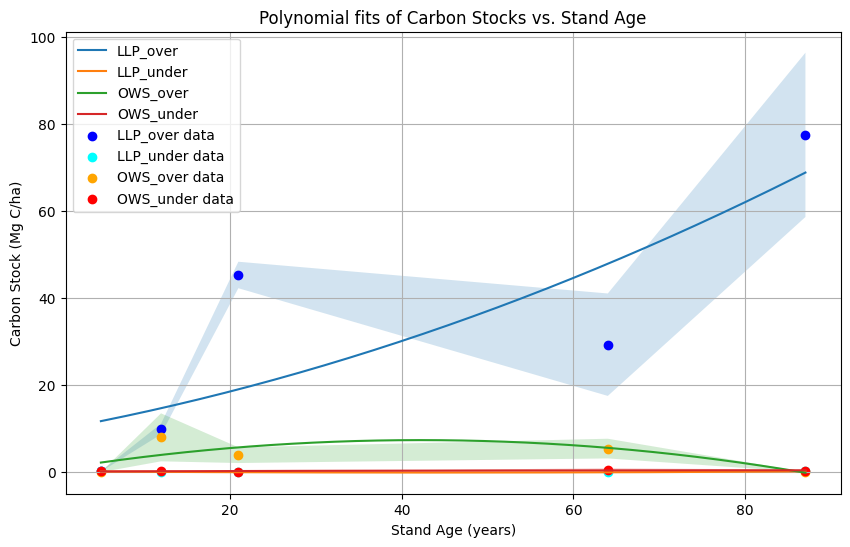

In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Input data from Table 5 (Mg C/ha)
# -------------------------------
# Stand ages
ages = np.array([5, 12, 21, 64, 87])

# LLP overstory ±SE
LLP_over_mean = np.array([0.17, 9.90, 45.28, 29.27, 77.45])
LLP_over_se   = np.array([0.06, 1.22, 3.04, 11.76, 18.86])

# LLP understory ±SE
LLP_under_mean = np.array([0.21, 0.0, 0.0, 0.0, 0.18])
LLP_under_se   = np.array([0.02, 0.0, 0.0, 0.0, 0.18])

# Other woody species overstory ±SE
OWS_over_mean = np.array([0.01, 8.0, 3.9, 5.42, 0.0])
OWS_over_se   = np.array([0.01, 5.51, 1.8, 2.26, 0.0])

# Other woody species understory ±SE
OWS_under_mean = np.array([0.23, 0.33, 0.005, 0.58, 0.36])
OWS_under_se   = np.array([0.17, 0.13, 0.005, 0.35, 0.21])

# -------------------------------
# Fit 2nd-degree polynomials
# -------------------------------
coeffs = {}
datasets = {
    'LLP_over': (LLP_over_mean, LLP_over_se),
    'LLP_under': (LLP_under_mean, LLP_under_se),
    'OWS_over': (OWS_over_mean, OWS_over_se),
    'OWS_under': (OWS_under_mean, OWS_under_se)
}

for name, (y, se) in datasets.items():
    p = np.polyfit(ages, y, 2)   # 2nd-degree polynomial
    coeffs[name] = p
    print(f"{name} polynomial coefficients (a,b,c): {p}")

# -------------------------------
# Evaluate polynomials and plot ±SE
# -------------------------------
x_plot = np.linspace(5, 87, 200)

plt.figure(figsize=(10,6))

for name, (y, se) in datasets.items():
    p = coeffs[name]
    y_fit = np.polyval(p, x_plot)
    plt.plot(x_plot, y_fit, label=name)
    plt.fill_between(ages, y-se, y+se, alpha=0.2)

plt.scatter(ages, LLP_over_mean, color='blue', label='LLP_over data')
plt.scatter(ages, LLP_under_mean, color='cyan', label='LLP_under data')
plt.scatter(ages, OWS_over_mean, color='orange', label='OWS_over data')
plt.scatter(ages, OWS_under_mean, color='red', label='OWS_under data')

plt.xlabel('Stand Age (years)')
plt.ylabel('Carbon Stock (Mg C/ha)')
plt.title('Polynomial fits of Carbon Stocks vs. Stand Age')
plt.legend()
plt.grid(True)
plt.show()


Initial df:
   AGB_Mean_tons_per_pixel  AGB_StdDev_per_acre_tons  \
0               177.330155                 10.638715   
1               128.209568                  0.115782   
2                71.584730                  4.172185   
3               161.131505                  2.325264   
4               177.199316                  1.250955   

   AGB_StdDev_tons_per_pixel  AGB_Total_tons  AGB_per_acre_tons     AOI_Zone  \
0                  33.140554      252.434691          81.036082  EIA_CS1_LLP   
1                  67.755025    36218.448857          61.891455  EIA_CS1_LLP   
2                  22.280176      185.839574          34.800314  EIA_CS1_LLP   
3                  45.530112     1527.905802          78.031546  EIA_CS1_LLP   
4                  47.318860     3206.960161          84.781475  EIA_CS1_LLP   

   Loreys_Height  Stand_Age  Tree_stock_percent         b1  ...  STATE_ABBR  \
0      42.826461  31.201379           54.650924  54.650924  ...         NaN   
1      48.26

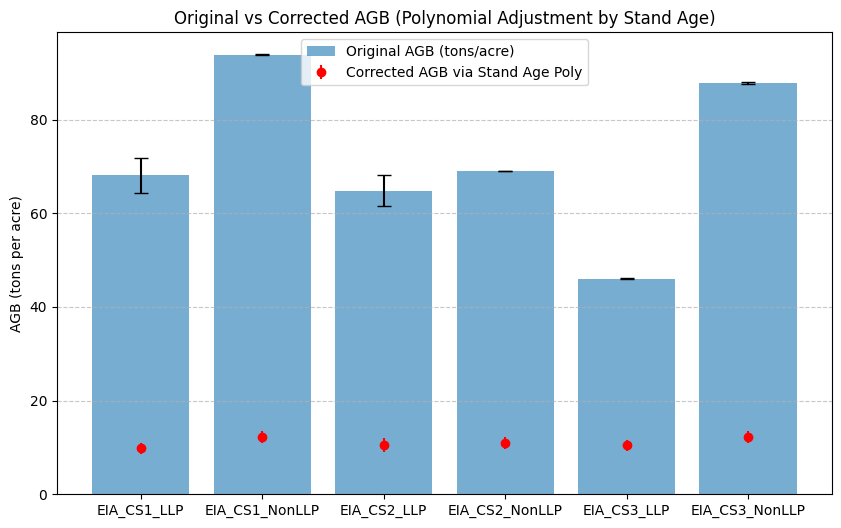

In [22]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# # Earth Engine -> Pandas
# # -------------------------------
df = geemap.ee_to_df(all_stats_with_stand)
print("Initial df:")
print(df.head())

# -------------------------------
# Polynomial fits from Table 5
# -------------------------------
# Stand ages
ages = np.array([5, 12, 21, 64, 87])

# LLP overstory ±SE (Mg C/ha)
LLP_over_mean = np.array([0.17, 9.90, 45.28, 29.27, 77.45])
LLP_over_se   = np.array([0.06, 1.22, 3.04, 11.76, 18.86])

# LLP understory ±SE
LLP_under_mean = np.array([0.21, 0.0, 0.0, 0.0, 0.18])
LLP_under_se   = np.array([0.02, 0.0, 0.0, 0.0, 0.18])

# Other woody species overstory ±SE
OWS_over_mean = np.array([0.01, 8.0, 3.9, 5.42, 0.0])
OWS_over_se   = np.array([0.01, 5.51, 1.8, 2.26, 0.0])

# Other woody species understory ±SE
OWS_under_mean = np.array([0.23, 0.33, 0.005, 0.58, 0.36])
OWS_under_se   = np.array([0.17, 0.13, 0.005, 0.35, 0.21])

# Fit 2nd-degree polynomials
coeffs = {}
datasets = {
    'LLP_over': (LLP_over_mean, LLP_over_se),
    'LLP_under': (LLP_under_mean, LLP_under_se),
    'OWS_over': (OWS_over_mean, OWS_over_se),
    'OWS_under': (OWS_under_mean, OWS_under_se)
}

for name, (y, se) in datasets.items():
    p = np.polyfit(ages, y, 2)   # quadratic fit
    coeffs[name] = p
    print(f"{name} polynomial coefficients (a,b,c): {p}")

# -------------------------------
# Conversion helper
# -------------------------------
# Mg C/ha -> tons/acre
MGHA_TO_TONAC = 1 / 2.47105

# -------------------------------
# Apply polynomial correction
# -------------------------------
def apply_poly_correction(row):
    age = row["Stand_Age"]

    # Choose polynomial based on AOI type
    if "LLP" in row["AOI_Zone"]:
        poly = coeffs["LLP_over"]
        se_array = LLP_over_se
        y_array = LLP_over_mean
    else:
        poly = coeffs["OWS_over"]
        se_array = OWS_over_se
        y_array = OWS_over_mean

    # Evaluate polynomial at given stand age
    agb_mgha = np.polyval(poly, age)

    # Convert to tons/acre
    agb_tonac = agb_mgha * MGHA_TO_TONAC

    # Approximate SE by nearest neighbor from Table 5
    idx = np.abs(ages - age).argmin()
    agb_se_mgha = se_array[idx]
    agb_se_tonac = agb_se_mgha * MGHA_TO_TONAC

    return pd.Series({
        "AGB_Correction_via_Stand_Age_Poly": agb_tonac,
        "AGB_Correction_via_Stand_Age_Poly_SE": agb_se_tonac
    })

df = df.join(df.apply(apply_poly_correction, axis=1))

# -------------------------------
# Summary table
# -------------------------------
summary = df.groupby("AOI_Zone").agg({
    "AGB_per_acre_tons": "mean",
    "AGB_StdDev_per_acre_tons": "mean",
    "Stand_Age": "mean",
    "Tree_stock_percent": "mean",
    "Loreys_Height": "mean",
    "AGB_Correction_via_Stand_Age_Poly": "mean",
    "AGB_Correction_via_Stand_Age_Poly_SE": "mean"
}).reset_index()

print("\nCorrected summary table:")
print(summary)

# -------------------------------
# Plot AGB vs Corrected AGB
# -------------------------------
plt.figure(figsize=(10,6))

plt.bar(
    summary["AOI_Zone"],
    summary["AGB_per_acre_tons"],
    yerr=summary["AGB_StdDev_per_acre_tons"],
    capsize=5,
    alpha=0.6,
    label="Original AGB (tons/acre)"
)

plt.errorbar(
    summary["AOI_Zone"],
    summary["AGB_Correction_via_Stand_Age_Poly"],
    yerr=summary["AGB_Correction_via_Stand_Age_Poly_SE"],
    fmt="o",
    color="red",
    label="Corrected AGB via Stand Age Poly"
)

plt.ylabel("AGB (tons per acre)")
plt.title("Original vs Corrected AGB (Polynomial Adjustment by Stand Age)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()